In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import json
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import networkx
from matplotlib import pyplot

In [3]:
from models import get_model
from toolbox.losses import mcp_loss
from toolbox import metrics, utils
from loaders.data_generator import MCP_Generator
from loaders.siamese_loaders import siamese_loader
from toolbox.metrics import all_losses_acc, accuracy_linear_assignment

In [137]:
def compute_a(n_vertices, edge_denstiy):
    return -np.log(edge_density)/np.log(n_vertices)

In [244]:
n_vertices = 100#200
edge_density = 0.7#0.12

In [245]:
edge_density*n_vertices

70.0

In [246]:
a = compute_a(n_vertices,edge_density)
a

0.0774509799928716

In [247]:
2/a+2*np.log(a)/(a*np.log(n_vertices))+2*np.log(np.exp(1)/2)/(a*np.log(n_vertices))+1

14.199205531330309

In [259]:
clique_size = 0
args= {}
args['edge_density'] = edge_density
args['clique_size'] = clique_size
args['num_examples_test'] = 1000
args['n_vertices'] = n_vertices
args['path_dataset'] = './dataset_mcp'

In [260]:
gen= MCP_Generator('test',args)

In [261]:
gen.load_dataset()

Creating dataset.
Saving datatset at ./dataset_mcp/MCP_1000_100_0_0.7/test.pkl


In [262]:
def get_device_config(model_path):
    config_file = os.path.join(model_path,'config.json')
    with open(config_file) as json_file:
        config_model = json.load(json_file)
    use_cuda = not config_model['cpu'] and torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    return config_model, device

def load_model(model_path, config, device):
    model = get_model(config['arch'])
    model.to(device)
    model_file = os.path.join(model_path,'model_best.pth.tar')
    checkpoint = torch.load(model_file)
    model.load_state_dict(checkpoint['state_dict'])
    return model

In [263]:
model_path = './runs/MCP-100/MCP_100_18_0.8/'
#model_path = f'./runs/MCP-100/MCP_100_{clique_size}_{edge_density}/'
config, device = get_device_config(model_path)
model = load_model(model_path,config,device)

Fetching model Simple_Edge_Embedding - Simple_Edge_Embedding 


In [264]:
test_loader = siamese_loader(gen, 16, gen.constant_n_vertices, shuffle=False)
clique_size_inference = 30#clique_size + 10

In [265]:
def get_inducedG(ind,g):
    g_rows = g[ind,:]
    return g_rows[:,ind]

def get_degrees(g):
    return np.sum(g,1)

def remove_node(g, x):
    return np.delete(np.delete(g,x,1),x,0)

def greedy_clique(g,ind=None):
    n_vertices = g.shape[0]
    #print(g.shape)
    if not ind:
        ind = list(range(n_vertices))
    deg = get_degrees(g)
    #print(min(deg), n_vertices,deg)
    if min(deg) == n_vertices-1:
        #print(ind)
        return ind
    else:
        low_deg = np.argmin(deg)
        #print(low_deg, ind)
        ind.pop(low_deg)
        #print(ind)
        return greedy_clique(remove_node(g,low_deg),ind)

def get_score(G,l):
    return len(greedy_clique(G.cpu().detach().numpy(),list(l.cpu().detach().numpy())))
    
def get_both_scores(G, proba, clique_size_inference=clique_size_inference):
    deg = torch.sum(proba[:,:],0)
    true_deg = torch.sum(G[:,:,1],1)
    _, ind = torch.topk(deg , clique_size_inference)
    _, ind_deg = torch.topk(true_deg, clique_size_inference)
    score = get_score(get_inducedG(ind,G[:,:,1]),ind)
    score_deg = get_score(get_inducedG(ind_deg,G[:,:,1]),ind_deg)
    return score, score_deg

def get_scores_batch(G,proba):
    scores = []
    scores_deg = []
    bs = G.shape[0]
    for i in range(bs):
        score, score_deg = get_both_scores(G[i,:,:,:], proba[i,:,:])
        scores.append(score)
        scores_deg.append(score_deg)
    return scores, scores_deg

In [266]:
all_scores = []
all_scores_deg = []
for G, K in test_loader:
    G = G.to(device)
    K = K.to(device)
    output = model(G)
    rawscores = output.squeeze(-1)
    proba = torch.softmax(rawscores,-1)
    scores, scores_deg = get_scores_batch(G,proba)
    all_scores += scores
    all_scores_deg += scores_deg
    #break

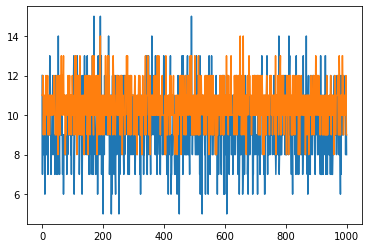

In [267]:
plt.plot(all_scores)
plt.plot(all_scores_deg)

In [268]:
np.mean(all_scores)

9.523

In [269]:
np.mean(all_scores_deg)

10.519

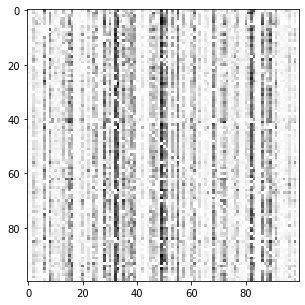

In [209]:
i=2
fig = pyplot.figure(figsize=(5, 5)) # in inches
pyplot.imshow(proba[i,:,:].cpu().detach().numpy(),
                  cmap="Greys",
                  interpolation="none")

In [210]:
G.shape

torch.Size([8, 100, 100, 2])

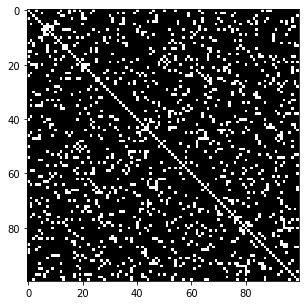

In [211]:
fig = pyplot.figure(figsize=(5, 5)) # in inches
pyplot.imshow(G[i,:,:,1].cpu().detach().numpy(),
                  cmap="Greys",
                  interpolation="none")

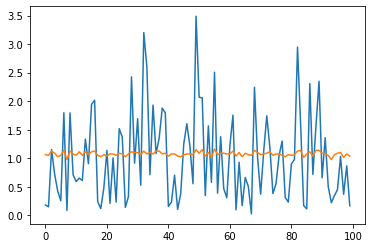

In [212]:
true_deg = torch.sum(G[i,:,:,1],1)
deg = torch.sum(proba[i,:,:],0)
plt.plot(deg.cpu().detach().numpy())
plt.plot(true_deg.cpu().detach().numpy()/80)

In [213]:
clique_size = 18 + 5

In [214]:
_, ind = torch.topk(deg , clique_size)
ind

tensor([49, 32, 82, 33, 55, 28, 89, 86, 68, 50, 51, 16, 15, 35, 38,  6, 39,  8,
        61, 72, 30, 83, 46], device='cuda:0')

In [215]:
_, ind_n = torch.topk(true_deg, clique_size)
ind_n

tensor([55, 51, 49, 89, 68, 83, 88,  6, 32, 37, 36, 82, 61, 16,  8,  2, 11, 28,
        13, 15, 73, 86, 29], device='cuda:0')

In [216]:
ind_s,_ = ind_n.sort()
G_rows = G[i,ind_s,:,1]
G_rows.shape

torch.Size([23, 100])

In [217]:
G_rows[:,ind_s]

tensor([[0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
         1., 1., 1., 1., 1.],
 

In [125]:
def bronk2(R, P, X, g):
    if not any((P, X)):
        yield R
    for v in P[:]:
        R_v = R + [v]
        P_v = [v1 for v1 in P if v1 in N(v, g)]
        X_v = [v1 for v1 in X if v1 in N(v, g)]
        for r in bronk2(R_v, P_v, X_v, g):
            yield r
        P.remove(v)
        X.append(v)

def N(v, g):
    return [i for i, n_v in enumerate(g[v]) if n_v]

def find_maxclique(g,ind=None,clique_size=0):
    l_clique = []
    if not ind:
        ind = range(g.shape[0])
    visited = set()
    l = clique_size
    for x in ind:
        #print(x,visited)
        if not (x in visited):
            for clique in bronk2([x],N(x,g),[],g):
                #print(set(clique))
                if len(clique) > l-1:
                    clique.sort()
                    print(clique)
                    l = len(clique)
                    visited.update(clique)
                    l_clique.append(clique)
                    #print(visited)
    return l_clique

In [126]:
gi = get_inducedG(ind, G[i,:,:,1])

In [109]:
l_clique_algo = find_maxclique(gi)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 

KeyboardInterrupt: 

In [130]:
def greedy_clique(g,ind=None):
    n_vertices = g.shape[0]
    #print(g.shape)
    if not ind:
        ind = list(range(n_vertices))
    deg = get_degrees(g)
    #print(min(deg), n_vertices,deg)
    if min(deg) == n_vertices-1:
        #print(ind)
        return ind
    else:
        low_deg = np.argmin(deg)
        #print(low_deg, ind)
        ind.pop(low_deg)
        #print(ind)
        return greedy_clique(remove_node(g,low_deg),ind)

def expand_clique(g, ind):
    N_all = set(ind)
    for v in ind:
        l_v = set(N(v,g))
        N_all.intersection(l_v)
    return N_all
        

In [131]:
gi = get_inducedG(ind, G[i,:,:,1])
#ind_s ,_ = ind.sort()
l_g = greedy_clique(gi.cpu().detach().numpy(),list(ind.cpu().detach().numpy()))

In [132]:
l_g

[92, 34, 8, 20, 80, 67, 37, 87, 43, 17, 16, 79, 54, 13, 96, 76, 1, 41, 21, 63]

In [135]:
len(expand_clique(G[i,:,:,1].cpu().detach().numpy(),l_g))

20

In [136]:
len(l_g)

20

In [151]:
get_degrees(get_inducedG(l_g,G[i,:,:,1].cpu().detach().numpy()))

array([17., 17., 17., 17., 17., 17., 17., 16., 16., 17., 17., 17., 17.,
       17., 16., 16., 17., 17.], dtype=float32)

In [165]:
gi = get_inducedG(ind_n, G[i,:,:,1])
#ind_s ,_ = ind_n.sort()
l_g_n = greedy_clique(gi.cpu().detach().numpy(),list(ind_n.cpu().detach().numpy()))

18.0 23 [21. 21. 22. 20. 19. 21. 21. 22. 20. 18. 18. 21. 21. 22. 21. 21. 18. 20.
 21. 21. 19. 20. 20.]
9 [74, 14, 11, 3, 66, 5, 32, 81, 62, 17, 86, 36, 6, 2, 7, 15, 73, 49, 42, 76, 70, 37, 9]
18.0 22 [20. 20. 21. 19. 19. 20. 20. 21. 19. 18. 21. 20. 21. 20. 20. 18. 19. 20.
 20. 18. 19. 19.]
9 [74, 14, 11, 3, 66, 5, 32, 81, 62, 86, 36, 6, 2, 7, 15, 73, 49, 42, 76, 70, 37, 9]
17.0 21 [19. 19. 20. 18. 18. 19. 19. 20. 18. 20. 19. 20. 19. 20. 17. 18. 19. 19.
 18. 18. 19.]
14 [74, 14, 11, 3, 66, 5, 32, 81, 62, 36, 6, 2, 7, 15, 73, 49, 42, 76, 70, 37, 9]
17.0 20 [19. 19. 19. 17. 17. 18. 18. 19. 17. 19. 18. 19. 18. 19. 18. 18. 18. 17.
 17. 18.]
3 [74, 14, 11, 3, 66, 5, 32, 81, 62, 36, 6, 2, 7, 15, 49, 42, 76, 70, 37, 9]
16.0 19 [18. 18. 18. 16. 17. 17. 18. 16. 18. 17. 18. 17. 18. 17. 17. 17. 17. 17.
 17.]
3 [74, 14, 11, 66, 5, 32, 81, 62, 36, 6, 2, 7, 15, 49, 42, 76, 70, 37, 9]
15.0 18 [17. 17. 17. 16. 17. 17. 15. 17. 17. 17. 16. 17. 16. 16. 16. 16. 16. 16.]
6 [74, 14, 11, 5, 32, 81, 62, 36, 6,

In [166]:
print(get_inducedG(l_g_n,G[i,:,:,1]))

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]],
       device='cuda:0')


In [40]:
l_len = [len(l) for l in l_clique]

In [42]:
max(l_len)

14

In [45]:
l_len_algo = [len(l) for l in l_clique_algo]
max(l_len_algo)

NameError: name 'l_clique_algo' is not defined

In [576]:
ind_greedy = [ind_n[i].item() for c in l_clique for i in c]

In [577]:
ind_greedy

[16, 17, 85, 79]

In [578]:
g = G[i,:,:,1]

In [579]:
#N(ind_greedy,g)

In [580]:
for cl in bronk2([ind_greedy[0]],N(ind_greedy[0],g),[],g):
    print(cl)

[16, 5, 17]
[16, 5, 47]
[16, 9, 87]
[16, 10]
[16, 14, 47]
[16, 17, 43]
[16, 17, 59]
[16, 30, 66]
[16, 33, 53]
[16, 33, 66]
[16, 33, 68]
[16, 40, 42]
[16, 40, 53]
[16, 42, 68]
[16, 43, 53]
[16, 46, 61]
[16, 48]
[16, 59, 66]


In [588]:
ind

tensor([35, 98, 27, 46], device='cuda:0')

In [586]:
l = find_maxclique(g,[x.item() for x in ind],clique_size-1)

[2, 35, 60]
[27, 35, 45, 69]
[35, 46, 54, 61]
[22, 49, 77, 98]


In [587]:
l = find_maxclique(g,[x.item() for x in ind_n],clique_size-1)

[5, 16, 17]
[5, 16, 47]
[9, 16, 87]
[14, 16, 47]
[16, 17, 43]
[16, 17, 59]
[16, 30, 66]
[16, 33, 53]
[16, 33, 66]
[16, 33, 68]
[16, 40, 42]
[16, 40, 53]
[16, 42, 68]
[16, 43, 53]
[16, 46, 61]
[16, 59, 66]
[0, 11, 85]
[0, 61, 85]
[11, 67, 85]
[43, 79, 85]
[47, 84, 85]
[47, 85, 97]
[50, 79, 85]
[67, 85, 97]
[70, 72, 85]
[70, 78, 85]


In [125]:
find_maxclique(range(n_vertices),g,clique_size)

[0, 1, 2, 3, 4]


In [26]:
arch = {} # Architecture and model
    
arch['arch']= 'Simple_Edge_Embedding' #'Simple_Node_Embedding'
arch['model_name'] = 'Simple_Edge_Embedding' #'Simple_Node_Embedding'
arch['num_blocks'] = 4
arch['original_features_num'] = 2
arch['in_features'] = 64
arch['out_features'] = 1
arch['depth_of_mlp'] = 3


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [61]:
weight = torch.ones((n_vertices,n_vertices))
scaling = n_vertices**2*edge_density/clique_size**2 #(n_vertices**2-clique_size**2)/clique_size**2
weight[:clique_size,:clique_size] = scaling * torch.ones((clique_size,clique_size))
weight= weight.to(device)
mcp_loss = torch.nn.BCELoss(weight=weight,reduction='none')
#weight = torch.ones(n_vertices)
#weight[:clique_size] = (n_vertices-clique_size)/clique_size*torch.ones(clique_size)
#weight = weight.to(device)
#mcp_loss = torch.nn.BCELoss(weight=weight,reduction='mean')

In [62]:
import trainer as trainer
train_loader = siamese_loader(gen, 16, gen.constant_n_vertices)
learning_rate = 1e-3

model = get_model(arch)
model.to(device);

Fetching model Simple_Edge_Embedding - Simple_Edge_Embedding 


In [63]:
optimizer = torch.optim.Adam(model.parameters(),
                            lr=learning_rate,
                            amsgrad=False)

In [64]:
#rawscores.shape
#labels = torch.diag(K[0,:,:,0])/(clique_size-1)
#labels.unsqueeze_(0)
#labels.shape
#labels.expand(16,-1).shape
#proba.shape

In [65]:
for i in range(10):
    for G, K in train_loader:
        G = G.to(device)
        K = K.to(device)
        output = model(G)
        rawscores = output.squeeze(-1)
        #bs = rawscores.shape[0]
        #proba = nn.Softmax(2)(rawscores.view(bs, 1, -1)).view_as(rawscores)
        proba = torch.softmax(rawscores,-1)
        loss = torch.mean(mcp_loss(proba,K[:,:,:,1])*G[:,:,:,1])
        #proba = torch.sigmoid(rawscores)
        #loss = mcp_loss(proba,labels.expand(bs,-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(i,loss.item())

0 5.796206951141357
1 1.4147557020187378
2 1.444758415222168
3 1.4515278339385986
4 1.4538531303405762
5 1.4739904403686523
6 1.3947932720184326
7 1.397053837776184
8 1.3096513748168945
9 1.333236575126648


In [87]:
optimizer = torch.optim.Adam(model.parameters(),
                            lr=1e-6,
                            amsgrad=False)

In [88]:
for i in range(10):
    for G, K in train_loader:
        G = G.to(device)
        K = K.to(device)
        output = model(G)
        rawscores = output.squeeze(-1)
        #bs = rawscores.shape[0]
        #proba = nn.Softmax(2)(rawscores.view(bs, 1, -1)).view_as(rawscores)
        proba = torch.softmax(rawscores,-1)
        loss = torch.mean(mcp_loss(proba,K[:,:,:,1])*G[:,:,:,1])
        #loss = mcp_loss(proba,K[:,:,:,1])
        #proba = torch.sigmoid(rawscores)
        #loss = mcp_loss(proba,labels.expand(bs,-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(i,loss.item())

0 1.2007036209106445
1 1.1318714618682861
2 1.144379734992981
3 1.1925218105316162
4 1.1654659509658813
5 1.2037657499313354
6 1.1738965511322021
7 1.1684999465942383
8 1.1523369550704956
9 1.1676394939422607


In [89]:
rawscores[5,:]

tensor([[240.7667, 241.5602, 240.9432,  ..., 235.6404, 238.7376, 235.1882],
        [247.4515, 248.1983, 247.6029,  ..., 242.1536, 245.3363, 241.6891],
        [247.2719, 248.0568, 247.3846,  ..., 241.9779, 245.1583, 241.5136],
        ...,
        [236.0364, 236.7858, 236.1810,  ..., 230.9590, 234.0187, 230.5391],
        [238.3931, 239.1499, 238.5388,  ..., 233.2891, 236.3292, 232.8411],
        [233.2477, 233.9884, 233.3907,  ..., 228.2534, 231.2537, 227.7947]],
       device='cuda:0', grad_fn=<SliceBackward>)

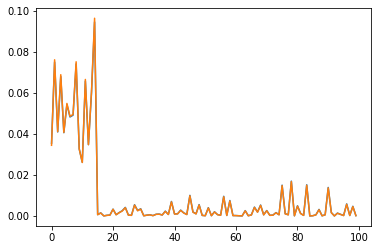

In [90]:
plt.plot(proba[5,20,:].cpu().detach().numpy());
plt.plot(proba[5,0,:].cpu().detach().numpy());

In [91]:
proba[5,3:8,:10]

tensor([[0.0355, 0.0778, 0.0413, 0.0675, 0.0409, 0.0555, 0.0490, 0.0499, 0.0767,
         0.0326],
        [0.0354, 0.0779, 0.0412, 0.0702, 0.0392, 0.0556, 0.0490, 0.0499, 0.0769,
         0.0325],
        [0.0354, 0.0754, 0.0410, 0.0683, 0.0406, 0.0532, 0.0484, 0.0493, 0.0744,
         0.0327],
        [0.0354, 0.0752, 0.0410, 0.0681, 0.0406, 0.0544, 0.0472, 0.0492, 0.0742,
         0.0327],
        [0.0354, 0.0766, 0.0411, 0.0692, 0.0407, 0.0550, 0.0487, 0.0480, 0.0756,
         0.0326]], device='cuda:0', grad_fn=<SliceBackward>)

In [92]:
rawscores[5,3:8,:10]

tensor([[247.4515, 248.2369, 247.6030, 248.0951, 247.5934, 247.8999, 247.7751,
         247.7941, 248.2235, 247.3674],
        [248.4422, 249.2304, 248.5940, 249.1268, 248.5444, 248.8921, 248.7668,
         248.7858, 249.2170, 248.3575],
        [237.7678, 238.5227, 237.9134, 238.4234, 237.9042, 238.1740, 238.0787,
         238.0970, 238.5098, 237.6869],
        [236.8611, 237.6130, 237.0060, 237.5143, 236.9970, 237.2903, 237.1474,
         237.1890, 237.6002, 236.7805],
        [242.7478, 243.5184, 242.8964, 243.4172, 242.8871, 243.1877, 243.0652,
         243.0510, 243.5052, 242.6652]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [93]:
deg = torch.sum(proba[5,:,:],0)

In [94]:
 _, ind = torch.topk(deg , clique_size)#torch.topk(deg, clique_size)

In [95]:
ind

tensor([14,  1,  8,  3, 11, 13,  5,  7,  6,  2,  4,  0, 12,  9, 10],
       device='cuda:0')

In [96]:
true_deg = torch.sum(G[5,:,:,1],1)

In [97]:
_, ind_n = torch.topk(true_deg, clique_size)

In [98]:
ind_n

tensor([83, 14,  4,  8,  3,  2,  1, 11, 75, 13, 90,  7, 46, 58, 12],
       device='cuda:0')

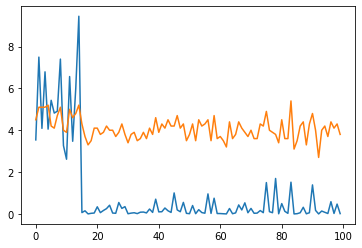

In [99]:
#plt.plot(deg.cpu().detach().numpy())
plt.plot(deg.cpu().detach().numpy())
plt.plot(true_deg.cpu().detach().numpy()/10)

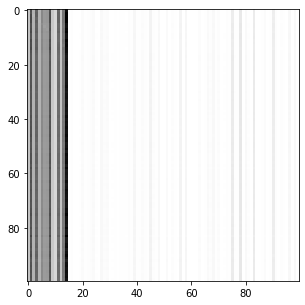

In [100]:
fig = pyplot.figure(figsize=(5, 5)) # in inches
pyplot.imshow(proba[5,:,:].cpu().detach().numpy(),
                  cmap="Greys",
                  interpolation="none")

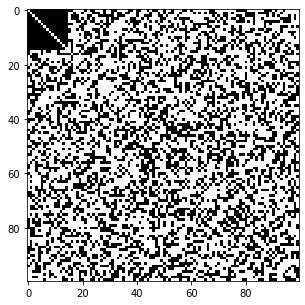

In [101]:
fig = pyplot.figure(figsize=(5, 5)) # in inches
pyplot.imshow(G[5,:,:,1].cpu().detach().numpy(),
                  cmap="Greys",
                  interpolation="none")

In [29]:
m = nn.Softmax2d()

In [30]:
input = torch.randn(2, 3, 12, 13)

In [31]:
output = m(input)

In [36]:
torch.sum(output[0,:,1,1])

tensor(1.)

In [173]:
K[5,:10,:10,1]

tensor([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [174]:
G[5,:10,:10,1]

tensor([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 1.],
        [1., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
        [1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [71]:
preds = torch.stack((torch.max(output[:,:5,:],1)[0],torch.max(output[:,5:,:],1)[0]),1)
probas = torch.log_softmax(preds,1)

In [72]:
torch.max(output[:,:5,:],1)[0].shape

torch.Size([16, 100])

In [73]:
probas[0,:,1]

tensor([-12864.7617,      0.0000], device='cuda:0', grad_fn=<SelectBackward>)

In [74]:
probas.shape

torch.Size([16, 2, 100])

In [75]:
target = torch.zeros_like(probas[:,0,:],dtype=torch.long)

In [76]:

target[:,:5] = torch.ones((16,5),dtype=torch.long)

In [77]:
target.shape

torch.Size([16, 100])

In [78]:
target[0,:10]

tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')

In [79]:
l_fun(probas,target)

tensor(14757.9775, device='cuda:0', grad_fn=<NllLoss2DBackward>)

In [23]:
def accuracy_max_mcp(weights,clique_size):
    """
    weights should be (bs,n,n) and labels (bs,n) numpy arrays
    """
    acc = 0
    total_n_vertices = 0
    for i, weight in enumerate(weights):
        weight = weight.cpu().detach().numpy()
        preds = np.argmax(weight, 1)
        #print(preds)
        acc += np.sum(preds[:clique_size] == 1)
        #acc += np.sum(preds[clique_size:] == 0)
        total_n_vertices += len(weight)
    return acc, total_n_vertices


In [24]:
accuracy_max_mcp(out,5)

(0, 500)